# Example calculation of PV potential for ERA5 data

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# location of era5 data on teachinghub
path="~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/"

In [3]:
year = 2000
months = range(6,9)
files = []

files = [f"era5-{year}-{month:02}.nc" for month in months]

files_path = [path+f for f in files]

print(f"Load data for {year=} {months=}")
files_path

Load data for year=2000 months=range(6, 9)


['~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-06.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-07.nc',
 '~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-08.nc']

In [4]:
ds=xr.open_mfdataset(files_path)

In [5]:
ds.info

<bound method Dataset.info of <xarray.Dataset> Size: 46GB
Dimensions:     (valid_time: 2208, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 18kB 2000-06-01 ... 2000-08-31T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 35kB dask.array<chunksize=(720,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 9GB dask.array<chunksize=(120, 121, 240), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 9GB dask.array<chunksize=(120, 121, 240), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 9GB dask.array<chunksize=(120, 121, 240), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 9GB dask.array<chunksize=(120, 121, 240), meta=np.ndarray>
    v10         (valid_time

In [28]:
ds.data_vars["ssrd"]

<xarray.DataArray 'ssrd' (valid_time: 2208, latitude: 721, longitude: 1440)> Size: 9GB
dask.array<concatenate, shape=(2208, 721, 1440), dtype=float32, chunksize=(124, 121, 240), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 18kB 2000-06-01 ... 2000-08-31T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 35kB dask.array<chunksize=(720,), meta=np.ndarray>
Attributes: (12/32)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...
    GRIB_surface:                             0.0

In [6]:
ds

<xarray.Dataset> Size: 46GB
Dimensions:     (valid_time: 2208, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 18kB 2000-06-01 ... 2000-08-31T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 35kB dask.array<chunksize=(720,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 9GB dask.array<chunksize=(120, 121, 240), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 9GB dask.array<chunksize=(120, 121, 240), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 9GB dask.array<chunksize=(120, 121, 240), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 9GB dask.array<chunksize=(120, 121, 240), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 9GB dask.array<chunksize=(120, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-22T21:21 GRIB to CDM+CF via cfgrib-0.9.1...

Calculate wind speed.

In [7]:
ds["wspd"] = np.sqrt(np.power(ds["u10"],2)+np.power(ds["v10"],2))

Calculate PV potential following Jerez et al. 2015, https://www.nature.com/articles/ncomms10014.

**Note:** radiative fluxes are accumulated over 1 hour, so we need to divided by seconds per hour to obtain fluxes in Wm-2.

In [8]:
sechour=3600 # secondd per hour

c1 = 4.3
c2 = 0.943
c3 = 0.028
c4 = -1.528

# cell temperature
T_cell = c1 + c2 * (ds.t2m - 273.15) + c3 * ds.ssrd/sechour + c4 * ds.wspd

# performance ratio
beta = -0.005
p_r = 1 + beta*(T_cell-25)

# pv potential
pv_pot = p_r * ds.ssrd/(sechour) * 1/1000

In [29]:
print(f"Memory usage before compute: {ds.nbytes / (1024 ** 3):.2f} GB")  # Convert to GB

Memory usage before compute: 51.24 GB


Calculate time-mean PV potential and plot as a map.

In [9]:
import time
start_time = time.time()
pv_pot_tmean = pv_pot.mean("valid_time").compute()
end_time = time.time()
compute_time = end_time - start_time
print(f"Time  {compute_time//60:.0f}m{compute_time%60:.3f}s")

Time  3m23.583s


In [19]:
print(f"Memory usage after compute: {ds.nbytes / (1024 ** 3):.2f} GB")  # Convert to GB


Memory usage after compute: 51.24 GB


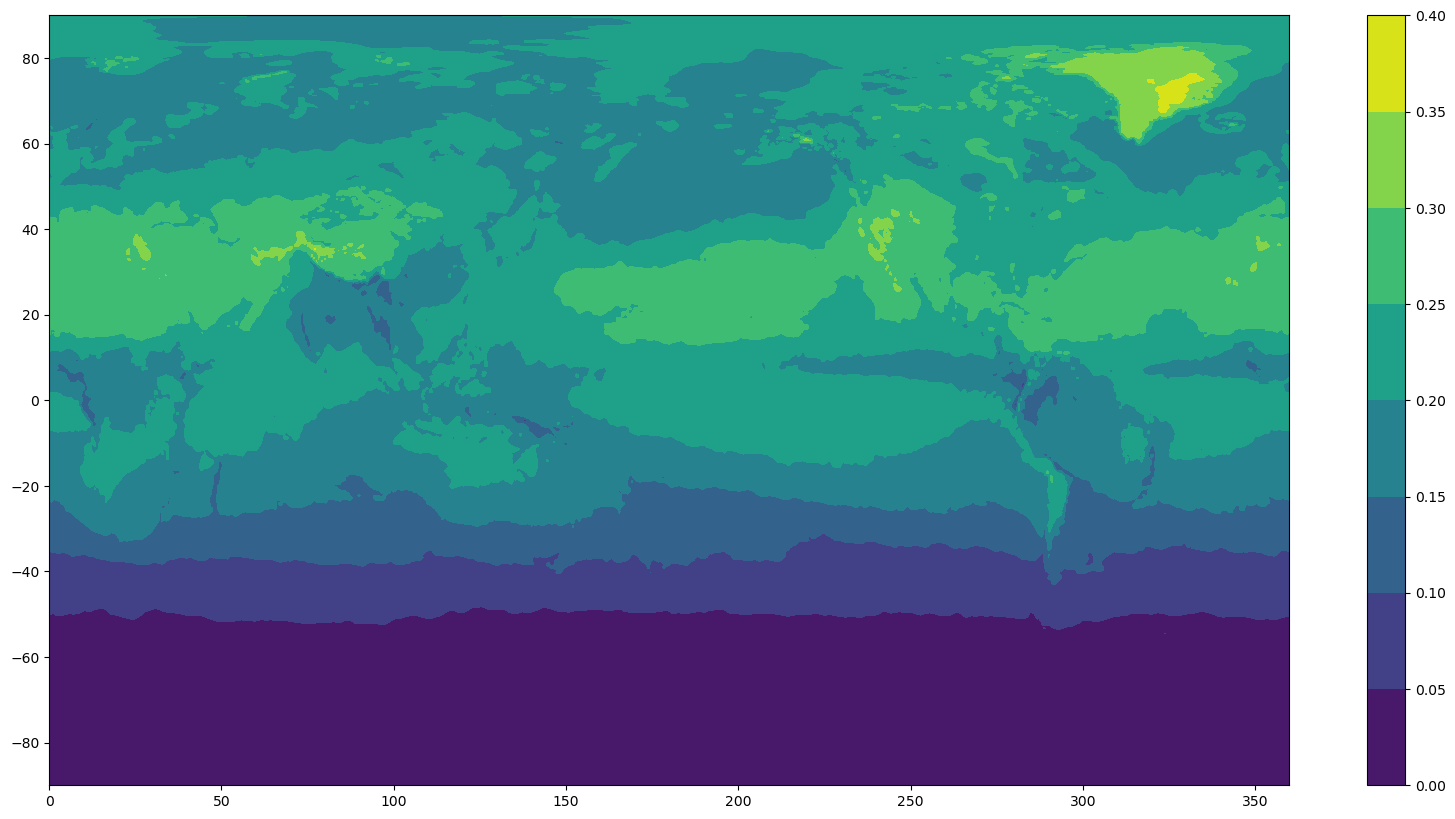

In [25]:
plt.figure(figsize=(20, 10))
plt.contourf(ds.longitude, ds.latitude, pv_pot_tmean)
plt.colorbar()

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

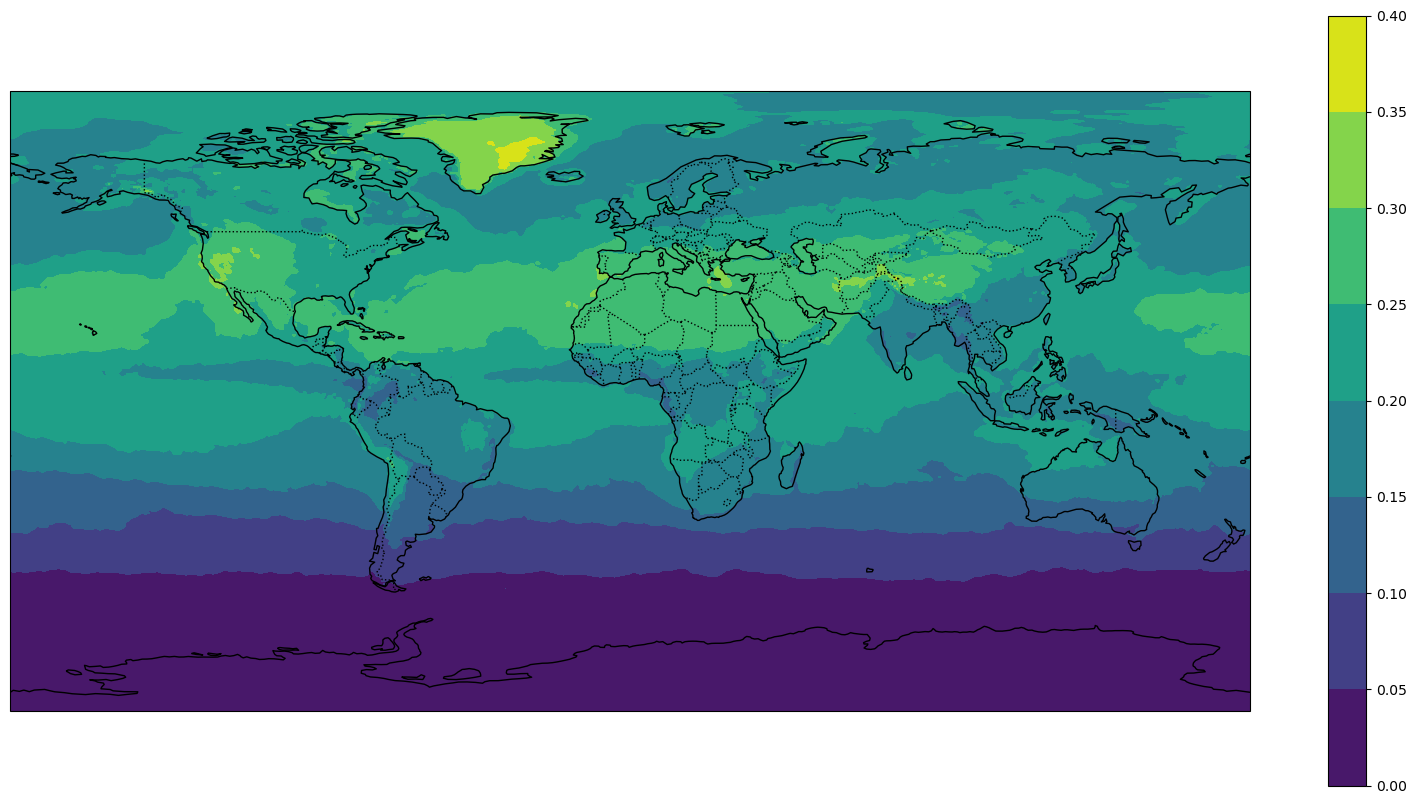

In [12]:
# Create a figure with a specified projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and other features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Create contour plot
contour = ax.contourf(ds.longitude, ds.latitude, pv_pot_tmean)

cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)

In [31]:
ds = ds.astype({'latitude': 'float32'})

ValueError: exact match required for all data variable names, but ['latitude'] != ['t2m', 'ssrd', 'ssrdc', 'u10', 'v10', 'wspd']: {'t2m', 'ssrdc', 'wspd', 'u10', 'latitude', 'ssrd', 'v10'} are not in both.

In [2]:
from dask.distributed import Client
client =Client('127.0.0.1:8786')  # Start a Dask client

OSError: Timed out trying to connect to tcp://127.0.0.1:8786 after 30 s